In [1]:
import hashlib
import numpy as np

## Helper Function

In [2]:
def vector_to_circulant(v, F):
    """
    Creates a circulant matrix from a vector v over Field F.
    Row 0: [v0, v1, v2, ... vr-1]
    Row 1: [vr-1, v0, v1, ... vr-2] (Right Shift)
    ...
    """
    r = len(v)
    rows = []
    # Convert input vector to a list for easy shifting
    current_row = list(v)
    
    for i in range(r):
        rows.append(current_row)
        # Rotate right for the next row
        # [a, b, c] -> [c, a, b]
        current_row = [current_row[-1]] + current_row[:-1]
        
    return matrix(F, r, r, rows)

print("[vec-to-circ] function defined.")

[vec-to-circ] function defined.


## Key Generation

In [3]:
def bike_keygen(r, w):
    """
    Generates BIKE keys.
    r: Block size (Prime number, e.g., 53)
    w: Weight of secret keys (must be even, split between h0 and h1)
    """
    F = GF(2)
    
    # 1. Generate Sparse Secret Keys (h0, h1)
    # Each has weight w/2
    w_half = w // 2
    
    # Helper to make random sparse vector
    def make_sparse(length, weight):
        vec = vector(F, length * [0])
        import random
        idxs = random.sample(range(length), weight)
        for i in idxs: vec[i] = 1
        return vec

    # We loop until h0 is invertible (required for public key)
    while True:
        h0 = make_sparse(r, w_half)
        h1 = make_sparse(r, w_half)
        
        # Convert to Circulant Matrices
        H0 = vector_to_circulant(h0, F)
        H1 = vector_to_circulant(h1, F)
        
        if H0.is_invertible():
            break
            
    # 2. Compute Public Key: H_pub = H1 * H0_inv
    H_pub = H1 * H0.inverse()
    
    # Private Key contains the vectors and matrices needed for decoding
    priv_key = {
        'h0': h0, 'h1': h1, 
        'H0': H0, 'H1': H1,
        'r': r
    }
    
    return H_pub, priv_key

print("[KeyGen] function defined")

[KeyGen] function defined


## Encapsulation

In [4]:
def bike_encapsulate(H_pub, t):
    """
    Bob creates a shared secret and encrypts it.
    t: Error threshold (weight of e0 and e1 combined)
    """
    r = H_pub.nrows()
    F = H_pub.base_ring()
    
    # 1. Generate Error Vectors (e0, e1)
    # Usually split weight t roughly equally, or t total. 
    # For simplicity, we put floor(t/2) in e0 and ceil(t/2) in e1
    w_e0 = t // 2
    w_e1 = t - w_e0
    
    def make_error(length, weight):
        vec = vector(F, length * [0])
        import random
        idxs = random.sample(range(length), weight)
        for i in idxs: vec[i] = 1
        return vec
        
    e0 = make_error(r, w_e0)
    e1 = make_error(r, w_e1)
    
    # 2. Compute Ciphertext: c = e0 + e1 * H_pub
    # Note: Vector * Matrix multiplication in Sage is row_vector * matrix
    c = e0 + (e1 * H_pub)
    
    # 3. Derive Shared Secret
    # Hash (e0 || e1)
    secret_input = str(e0) + str(e1)
    shared_secret = hashlib.sha256(secret_input.encode('utf-8')).hexdigest()
    
    return c, shared_secret

print("[Encap] function defined")

[Encap] function defined


## Decapsulation

In [11]:
def bike_decapsulate(c, priv_key, t, max_iters=20):
    """
    Alice recovers e0, e1 using Bit Flipping.
    """
    H0 = priv_key['H0']
    H1 = priv_key['H1'] # Needed to compute syndrome part for e1 checks
    h0 = priv_key['h0']
    h1 = priv_key['h1']
    r = priv_key['r']
    F = GF(2)
    
    # 1. Compute Initial Syndrome
    # s = c * H0  (This works because c = e0 + e1*H1*H0_inv -> c*H0 = e0*H0 + e1*H1)
    syndrome = c * H0
    
    # Candidates for e0 and e1 (Start as all zeros)
    # We essentially decode 'in place' by tracking changes, 
    # but strictly speaking we are finding e0, e1 to subtract them.
    # In this simplified BFD, we will just try to find e0', e1' that produce the syndrome.
    e0_hat = vector(F, r*[0])
    e1_hat = vector(F, r*[0])
    
    # Pre-compute column indices where h0 and h1 are 1
    # This speeds up the "Counter" step significantly
    h0_locs = [i for i, val in enumerate(h0) if val == 1]
    h1_locs = [i for i, val in enumerate(h1) if val == 1]
    
    for iteration in range(max_iters):
        # Calculate current syndrome based on our guesses so far
        # current_S = s - (e0_hat*H0 + e1_hat*H1)
        # Note: In GF(2), subtraction is addition.
        current_S = syndrome + (e0_hat * H0) + (e1_hat * H1)
        
        # If syndrome is all zeros, we are done!
        if current_S.hamming_weight() == 0:
            break
            
        # --- ITERATIVE FLIPPING STEP ---
        # We need to count "Unsatisfied Parity Checks" (UPC) for every bit position
        
        # A bit i in e0 affects syndrome positions: (i + loc) % r for loc in h0_locs
        # We verify this by checking correlation
        
        upc_e0 = [0] * r
        upc_e1 = [0] * r
        
        # Count for e0
        for i in range(r):
            count = 0
            for loc in h0_locs:
                # The column logic in circulant matrices corresponds to (i + loc) % r 
                # (depending on transpose definition, simplified here as rotational matching)
                if current_S[(i + loc) % r] == 1:
                    count += 1
            upc_e0[i] = count
            
        # Count for e1
        for i in range(r):
            count = 0
            for loc in h1_locs:
                if current_S[(i + loc) % r] == 1:
                    count += 1
            upc_e1[i] = count
            
        # Determine Threshold (Simple Strategy: Max UPC)
        max_matches = max(max(upc_e0), max(upc_e1))
        
        # If max matches is too low, we might be stuck (or finished imperfectly)
        # For this toy version, we stop if threshold is very low to avoid infinite loops
        if max_matches <= len(h0_locs) // 2: 
            break
            
        # Flip bits that meet the threshold
        # We use a strict threshold (max_matches) to be safe
        threshold = max_matches
        
        for i in range(r):
            if upc_e0[i] >= threshold:
                e0_hat[i] += 1 # Flip (0->1 or 1->0)
        for i in range(r):
            if upc_e1[i] >= threshold:
                e1_hat[i] += 1 # Flip
                
    # 2. Final Output
    # The errors we found are e0_hat, e1_hat.
    # We define the recovered error as our guess.
    
    # Derive Shared Secret
    secret_input = str(e0_hat) + str(e1_hat)
    shared_secret = hashlib.sha256(secret_input.encode('utf-8')).hexdigest()
    
    return shared_secret

print("[Decap] function defined")

[Decap] function defined


In [6]:
# ==========================================
# 5. VERIFICATION TEST
# ==========================================
# Parameters for a "Toy" instance
r_toy = 53  # Block size (Prime)
w_toy = 6   # Weight of h0, h1 (Small & Even)
t_toy = 4   # Error weight

print(f"--- Running BIKE Test (r={r_toy}, w={w_toy}, t={t_toy}) ---")

# 1. KeyGen
H_pub, priv = bike_keygen(r_toy, w_toy)
print("Keys Generated.")

# 2. Encapsulate
c, secret_bob = bike_encapsulate(H_pub, t_toy)
print(f"Bob's Secret:   {secret_bob[:10]}...")

# 3. Decapsulate
secret_alice = bike_decapsulate(c, priv, t_toy)
print(f"Alice's Secret: {secret_alice[:10]}...")

# 4. Check
if secret_bob == secret_alice:
    print("SUCCESS: Secrets Match!")
else:
    print("FAILURE: Secrets do not match.")

--- Running BIKE Test (r=53, w=6, t=4) ---
Keys Generated.
Bob's Secret:   587b200140...
Alice's Secret: 587b200140...
SUCCESS: Secrets Match!


# Attack

In [7]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [8]:
def bike_isd_check(H_pub, c, t, max_iters=1000):
    """
    Attempts to break BIKE using Prange's ISD algorithm.
    Returns True if successful, False otherwise.
    """
    r = H_pub.nrows()
    F = H_pub.base_ring()
    n_total = 2 * r
    
    # 1. Construct the Parity Check Matrix for Attack
    # H_attack = [H_pub^T | I]
    # We solve H_attack * e_col = c_col
    H_attack = block_matrix(F, 1, [H_pub.transpose(), identity_matrix(F, r)])
    
    # The target syndrome is the ciphertext (transposed)
    s = c
    
    for _ in range(max_iters):
        # 2. Pick a random Information Set (r columns indices)
        # Instead of shuffling the whole matrix (slow), we pick random columns
        import random
        idxs = random.sample(range(n_total), r)
        
        # 3. Extract submatrix
        H_sub = H_attack.matrix_from_columns(idxs)
        
        # 4. Check Invertibility
        if not H_sub.is_invertible():
            continue
            
        # 5. Solve: H_sub * e_sub = s  =>  e_sub = H_sub^-1 * s
        # Note: Sage handles 'Matrix * Vector' as Matrix * ColumnVector
        try:
            e_candidate = H_sub.inverse() * s
            
            # 6. Check Weight
            # Prange assumes ALL errors are located in the chosen columns.
            # So if the weight of this solution is <= t, we likely found it.
            if e_candidate.hamming_weight() == t:
                return True
        except:
            continue
            
    return False

print("[Attack] Function Defined.")

[Attack] Function Defined.


In [9]:
def run_bike_3param_experiment(r_list, t_list, w_list, trials=5, max_iters=1000):
    results_list = []
    
    # Sanity Check inputs
    if not r_list or not t_list or not w_list:
        print("ERROR: One of the input lists (r, t, or w) is empty!")
        return pd.DataFrame()

    total_configs = len(r_list) * len(t_list) * len(w_list)
    config_idx = 0
    
    print(f"--- Starting BIKE Testbed (Robust Mode) ---")
    print(f"Total Configurations: {total_configs}")
    print(f"r values: {r_list}")
    print(f"w values: {w_list}")
    print(f"t values: {t_list}")
    print("=" * 65)
    
    for r in r_list:
        r = int(r)
        
        for w in w_list:
            w = int(w)
            
            # CHECK 1: Is weight valid?
            if w % 2 != 0:
                print(f"[Skipping] r={r}, w={w} -> Weight must be even.")
                continue
            if w >= r:
                print(f"[Skipping] r={r}, w={w} -> Weight w must be < Block Size r.")
                continue
            
            for t in t_list:
                t = int(t)
                config_idx += 1
                
                print(f"\n[Set {config_idx}/{total_configs}] Parameters: r={r}, w={w}, t={t}")
                
                success_count = 0
                valid_trials = 0
                start_time_batch = time.time()
                
                for i in range(trials):
                    print(f"    Trial {i+1:>2}/{trials} ...", end=" ", flush=True)
                    
                    trial_start = time.time()
                    
                    # --- A. Generate System ---
                    # Removed try-except so we see CRASHES if they happen
                    H_pub, priv = bike_keygen(r, w)
                        
                    valid_trials += 1
                    
                    # --- B. Encapsulate ---
                    c, _ = bike_encapsulate(H_pub, t)
                    
                    # --- C. Attack ---
                    is_broken = bike_isd_check(H_pub, c, t, max_iters=max_iters)
                    
                    duration = time.time() - trial_start
                    
                    if is_broken:
                        success_count += 1
                        print(f"BROKEN  (in {duration:.2f}s)")
                    else:
                        print(f"SECURE  (in {duration:.2f}s)")
                
                # Log Summary
                if valid_trials > 0:
                    rate = float(success_count) / float(valid_trials)
                    batch_time = time.time() - start_time_batch
                    print(f"  >> Result: {rate:.0%} Success (Batch took {batch_time:.1f}s)")
                    
                    results_list.append({
                        'r': r,
                        'w': w,
                        't': t,
                        'success_rate': rate
                    })

    print("\n" + "="*65)
    print("Experiment Complete.")
    return pd.DataFrame(results_list)

print("[Testbed] function defined.")

[Testbed] function defined.


In [10]:
# A. Define Ranges
# r_vals = [53, 59, 61, 67, 71, 73, 79, 83, 89]

r_vals = [59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 127, 137, 139, 149, 151, 157, 163, 167]
t_vals = [4, 6, 8]

# Weight w: Small even numbers (Toy keys are usually sparse)
# We test a few values to see if it impacts the attack
w_vals = [6] 

# B. Run
# Budget: 1000 iterations (Quick check)
df_results = run_bike_3param_experiment(r_vals, t_vals, w_vals, trials=10, max_iters=5000)

--- Starting BIKE Testbed (Robust Mode) ---
Total Configurations: 54
r values: [59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 127, 137, 139, 149, 151, 157, 163, 167]
w values: [6]
t values: [4, 6, 8]

[Set 1/54] Parameters: r=59, w=6, t=4
    Trial  1/10 ... BROKEN  (in 0.01s)
    Trial  2/10 ... BROKEN  (in 0.03s)
    Trial  3/10 ... BROKEN  (in 0.00s)
    Trial  4/10 ... BROKEN  (in 0.01s)
    Trial  5/10 ... BROKEN  (in 0.06s)
    Trial  6/10 ... BROKEN  (in 0.03s)
    Trial  7/10 ... BROKEN  (in 0.00s)
    Trial  8/10 ... BROKEN  (in 0.11s)
    Trial  9/10 ... BROKEN  (in 0.02s)
    Trial 10/10 ... BROKEN  (in 0.01s)
  >> Result: 100% Success (Batch took 0.3s)

[Set 2/54] Parameters: r=59, w=6, t=6
    Trial  1/10 ... BROKEN  (in 0.08s)
    Trial  2/10 ... BROKEN  (in 0.09s)
    Trial  3/10 ... BROKEN  (in 0.01s)
    Trial  4/10 ... BROKEN  (in 0.06s)
    Trial  5/10 ... BROKEN  (in 0.01s)
    Trial  6/10 ... BROKEN  (in 0.00s)
    Trial  7/10 ... SECURE  (in 0.18s)
    Trial  8/10 ... 

## Visualizations


Visualizing results for Key Weight w=6


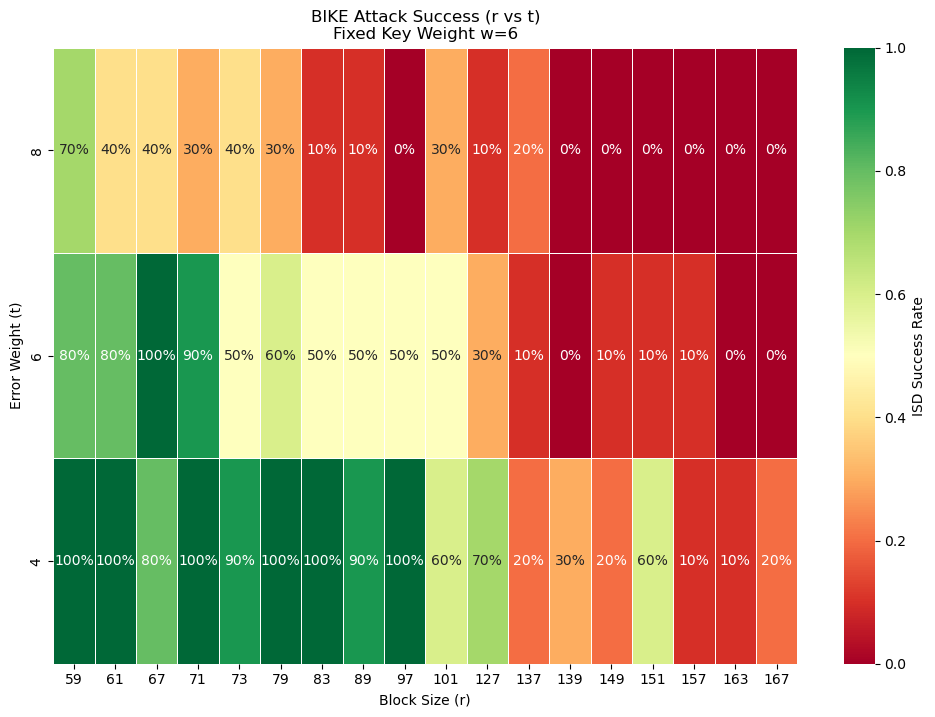

In [11]:
# ==========================================
# 4. VISUALIZATION
# ==========================================
if not df_results.empty:
    # Since we have 3 parameters, we should visualize r vs t
    # and average over w (or pick one w).
    # Theory says w shouldn't matter for *this* specific attack.
    
    # Let's filter for one weight (e.g., w=6) to get a clean 2D plot
    target_w = 6
    subset = df_results[df_results['w'] == target_w]
    
    if subset.empty and not df_results.empty:
        # If w=6 wasn't valid for some r, just take the first available w
        target_w = df_results['w'].iloc[0]
        subset = df_results[df_results['w'] == target_w]

    print(f"\nVisualizing results for Key Weight w={target_w}")
    
    pivot = subset.pivot_table(index='t', columns='r', values='success_rate')
    pivot = pivot.sort_index(ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot, 
        annot=True, 
        fmt=".0%", 
        cmap="RdYlGn", 
        cbar_kws={'label': 'ISD Success Rate'},
        linewidths=.5
    )
    plt.title(f'BIKE Attack Success (r vs t)\nFixed Key Weight w={target_w}')
    plt.xlabel('Block Size (r)')
    plt.ylabel('Error Weight (t)')
    plt.show()
    
else:
    print("No results found.")

In [38]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sage.all import *

# ==========================================
# 1. ROBUST BIKE SIZE CALCULATOR
# ==========================================
def get_bike_size_kb(obj):
    """
    Attempts to measure object size. Returns 0 if it fails, 
    allowing the main loop to use the theoretical fallback.
    """
    try:
        # CASE A: Tuple/List (e.g. Private Key h0, h1)
        if isinstance(obj, (tuple, list)):
            return sum(get_bike_size_kb(x) for x in obj)
            
        # CASE B: Sage Matrix/Vector
        if hasattr(obj, 'nrows'):
            return float((obj.nrows() * obj.ncols()) / 8192) # bits->KB
        if hasattr(obj, 'length'):
            return float(len(obj) / 8192)

        # CASE C: Polynomials (The tricky part)
        # Try to lift from Quotient Ring to get actual degree
        if hasattr(obj, 'lift'):
            return float((obj.lift().degree() + 1) / 8192)
        if hasattr(obj, 'degree'):
            return float((obj.degree() + 1) / 8192)
            
    except:
        return 0.0
    return 0.0

# ==========================================
# 2. METRICS EXPERIMENT RUNNER (Fixed)
# ==========================================
def run_bike_metrics(r_list, w, t, trials=10):
    results_time = []
    results_size = []
    
    print(f"--- Starting BIKE Metrics Test (w={w}, t={t}) ---")
    
    for r_val in r_list:
        time.sleep(float(0.5))
        r = int(r_val)
        
        # Constraint Check
        if w >= r:
            continue
            
        print(f"Testing r={r}...", end=" ", flush=True)
        
        # --- A. SIZE METRICS (With Fallback) ---
        try:
            H_pub, priv = bike_keygen(r, w)
            
            # Measure
            kb_pub = get_bike_size_kb(H_pub)
            kb_priv = get_bike_size_kb(priv)
            
            # [FIX] Theoretical Fallback if measurement fails (returns ~0)
            # Public Key = r bits
            # Private Key = 2*r bits (h0, h1)
            if kb_pub < 0.0001:
                kb_pub = float(r / 8 / 1024)
            if kb_priv < 0.0001:
                kb_priv = float((2 * r) / 8 / 1024)
            
            results_size.append({
                'r': r,
                'w': w,
                't': t,
                'Public Key (KB)': kb_pub,
                'Private Key (KB)': kb_priv
            })
        except Exception as e:
            print(f"[Size Error: {e}]", end=" ")
            # Continue anyway to test timing
            kb_pub = 0

        # --- B. TIMING METRICS ---
        t_keygen = 0
        t_encap = 0
        t_decap = 0
        valid = 0
        
        for _ in range(trials):
            try:
                # 1. KeyGen
                t0 = time.time()
                H_pub, priv = bike_keygen(r, w)
                t_keygen += (time.time() - t0)
                
                # 2. Encap
                t0 = time.time()
                ciphertext, ss_encap = bike_encapsulate(H_pub, t)
                t_encap += (time.time() - t0)
                
                # 3. Decap
                t0 = time.time()
                # [FIX] Added 't' parameter to decapsulate
                ss_decap = bike_decapsulate(ciphertext, priv, t) 
                t_decap += (time.time() - t0)
                
                valid += 1
            except Exception as e:
                # print(f"Trial fail: {e}") 
                continue
                
        if valid > 0:
            avg_keygen = (t_keygen / valid) * 1000
            avg_encap = (t_encap / valid) * 1000
            avg_decap = (t_decap / valid) * 1000
            
            results_time.append({
                'r': r,
                'KeyGen (ms)': avg_keygen,
                'Encapsulate (ms)': avg_encap,
                'Decapsulate (ms)': avg_decap
            })
            print(f"Done. (Pub: {kb_pub:.2f} KB | Encap: {avg_encap:.2f} ms)")
        else:
            print("Failed all timing trials.")
            
    return pd.DataFrame(results_size), pd.DataFrame(results_time)

# ==========================================
# 3. EXECUTION
# ==========================================
# BIKE parameters (r must be prime for GF(2)[x]/(x^r-1) ideally, or coprime to 2)
# We use a mix of small and medium primes.
r_test_values = [
    151, 181, 223, 263, 271, 307, 347, 379, 419, 463, 499, 547, 587
]

w_fixed = 6
t_fixed = 8

In [39]:
df_bike_size, df_bike_time = run_bike_metrics(r_test_values, w_fixed, t_fixed, trials=10)

--- Starting BIKE Metrics Test (w=6, t=8) ---
Testing r=151... Done. (Pub: 2.78 KB | Encap: 1.10 ms)
Testing r=181... Done. (Pub: 4.00 KB | Encap: 1.24 ms)
Testing r=223... Done. (Pub: 6.07 KB | Encap: 1.59 ms)
Testing r=263... Done. (Pub: 8.44 KB | Encap: 2.22 ms)
Testing r=271... Done. (Pub: 8.96 KB | Encap: 1.91 ms)
Testing r=307... Done. (Pub: 11.51 KB | Encap: 2.13 ms)
Testing r=347... Done. (Pub: 14.70 KB | Encap: 2.41 ms)
Testing r=379... Done. (Pub: 17.53 KB | Encap: 2.64 ms)
Testing r=419... Done. (Pub: 21.43 KB | Encap: 2.84 ms)
Testing r=463... Done. (Pub: 26.17 KB | Encap: 3.10 ms)
Testing r=499... Done. (Pub: 30.40 KB | Encap: 3.30 ms)
Testing r=547... Done. (Pub: 36.52 KB | Encap: 3.56 ms)
Testing r=587... Done. (Pub: 42.06 KB | Encap: 3.77 ms)


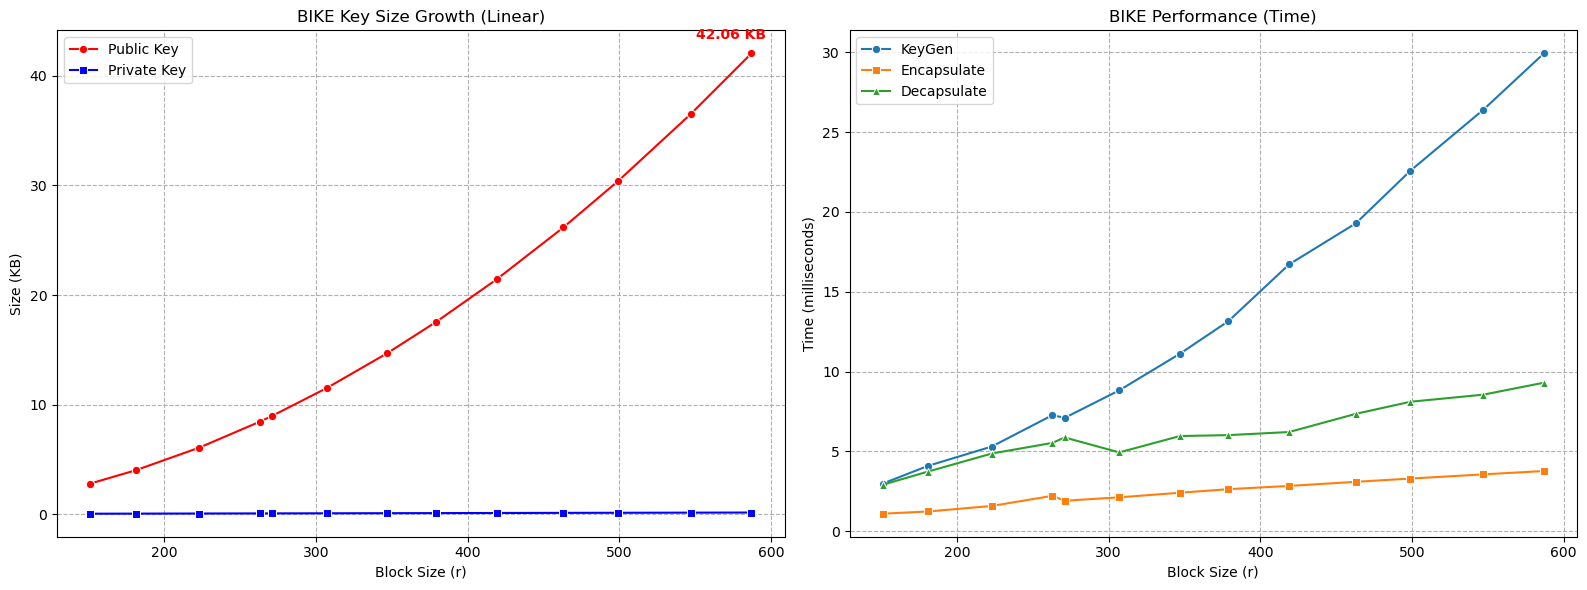


--- BIKE Key Size Data ---
      r  Public Key (KB)
0   151         2.783325
1   181         3.999146
2   223         6.070435
3   263         8.443481
4   271         8.964966
5   307        11.505005
6   347        14.698364
7   379        17.534302
8   419        21.430786
9   463        26.168091
10  499        30.395630
11  547        36.524536
12  587        42.061646


In [40]:
# ==========================================
# VISUALIZATION
# ==========================================
if not df_bike_size.empty and not df_bike_time.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- PLOT 1: Key Sizes ---
    sns.lineplot(data=df_bike_size, x='r', y='Public Key (KB)', 
                 marker='o', label='Public Key', color='red', ax=ax1)
    sns.lineplot(data=df_bike_size, x='r', y='Private Key (KB)', 
                 marker='s', label='Private Key', color='blue', ax=ax1)
    
    ax1.set_title('BIKE Key Size Growth (Linear)')
    ax1.set_ylabel('Size (KB)')
    ax1.set_xlabel('Block Size (r)')
    ax1.grid(True, linestyle='--')
    ax1.legend()
    
    # Annotate max public key
    last_idx = int(len(df_bike_size) - 1)
    max_r = df_bike_size['r'].iloc[last_idx]
    max_size = df_bike_size['Public Key (KB)'].iloc[last_idx]
    ax1.annotate(f"{max_size:.2f} KB", xy=(max_r, max_size), 
                 xytext=(-40, 10), textcoords='offset points', color='red', fontweight='bold')

    # --- PLOT 2: Timing ---
    sns.lineplot(data=df_bike_time, x='r', y='KeyGen (ms)', marker='o', label='KeyGen', ax=ax2)
    sns.lineplot(data=df_bike_time, x='r', y='Encapsulate (ms)', marker='s', label='Encapsulate', ax=ax2)
    sns.lineplot(data=df_bike_time, x='r', y='Decapsulate (ms)', marker='^', label='Decapsulate', ax=ax2)
    
    ax2.set_title('BIKE Performance (Time)')
    ax2.set_ylabel('Time (milliseconds)')
    ax2.set_xlabel('Block Size (r)')
    ax2.grid(True, linestyle='--')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- BIKE Key Size Data ---")
    print(df_bike_size[['r', 'Public Key (KB)']])

--- Starting BIKE Dynamic Key Size Test ---
Generating keys for r=151... Done. (Pub: 0.0184 KB | Priv: 0.0369 KB)
Generating keys for r=181... Done. (Pub: 0.0221 KB | Priv: 0.0442 KB)
Generating keys for r=223... Done. (Pub: 0.0272 KB | Priv: 0.0544 KB)
Generating keys for r=263... Done. (Pub: 0.0321 KB | Priv: 0.0642 KB)
Generating keys for r=271... Done. (Pub: 0.0331 KB | Priv: 0.0662 KB)
Generating keys for r=307... Done. (Pub: 0.0375 KB | Priv: 0.0750 KB)
Generating keys for r=347... Done. (Pub: 0.0424 KB | Priv: 0.0847 KB)
Generating keys for r=379... Done. (Pub: 0.0463 KB | Priv: 0.0925 KB)
Generating keys for r=419... Done. (Pub: 0.0511 KB | Priv: 0.1023 KB)
Generating keys for r=463... Done. (Pub: 0.0565 KB | Priv: 0.1130 KB)
Generating keys for r=499... Done. (Pub: 0.0609 KB | Priv: 0.1218 KB)
Generating keys for r=547... Done. (Pub: 0.0668 KB | Priv: 0.1335 KB)
Generating keys for r=587... Done. (Pub: 0.0717 KB | Priv: 0.1433 KB)


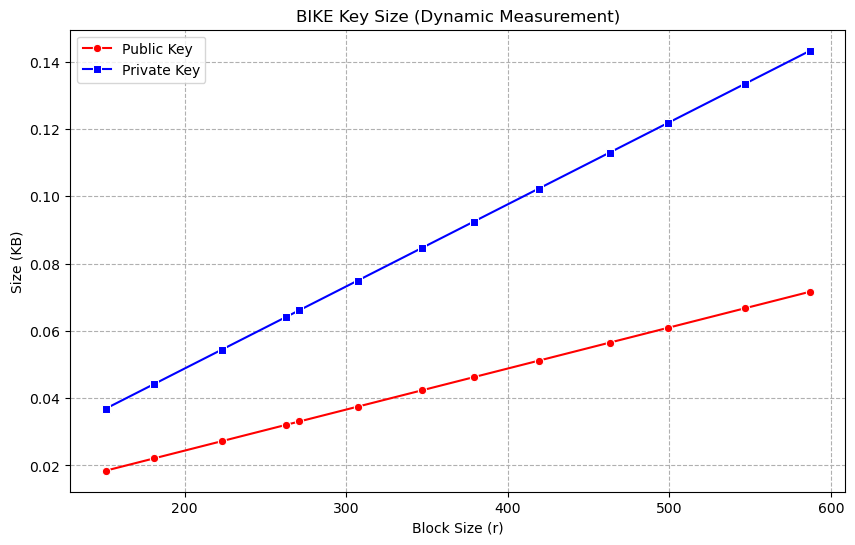

In [47]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sage.all import *

# ==========================================
# 1. FIXED SIZE CALCULATOR (Handles Dicts)
# ==========================================
def get_compressed_size_kb_fixed(obj):
    """
    Measures the size of the 'Protocol Format' from the raw Sage objects.
    Now supports Dictionaries for private keys.
    """
    bits = 0
    try:
        # CASE A: Public Key (The Matrix H) -> We measure just 1 row
        if hasattr(obj, 'nrows'):
            first_row = obj[0] 
            bits = len(first_row)
            
        # CASE B: Private Key (Dictionary) -> Your specific format
        elif isinstance(obj, dict):
            # Sum the size of h0 and h1 vectors
            if 'h0' in obj and 'h1' in obj:
                bits += len(obj['h0'])
                bits += len(obj['h1'])
        
        # CASE C: Private Key (Tuple) -> Fallback for other implementations
        elif isinstance(obj, tuple):
            for part in obj:
                if hasattr(part, 'length'): 
                    bits += len(part)
                    
    except Exception as e:
        # print(f"Meas Error: {e}")
        return 0
        
    return float(bits / 8 / 1024) # Bits -> Bytes -> KB

# ==========================================
# 2. EXPERIMENT RUNNER
# ==========================================
def run_bike_dynamic_size_test(r_list, w):
    results_size = []
    
    print(f"--- Starting BIKE Dynamic Key Size Test ---")
    
    for r_val in r_list:
        r = int(r_val)
        
        # Constraint Check
        if w >= r: continue
            
        print(f"Generating keys for r={r}...", end=" ", flush=True)
        
        try:
            # 1. ACTUALLY GENERATE THE KEYS using your function
            H_pub, priv = bike_keygen(r, w)
            
            # 2. Measure using the FIXED function
            kb_pub = get_compressed_size_kb_fixed(H_pub)
            kb_priv = get_compressed_size_kb_fixed(priv)
            
            results_size.append({
                'r': r,
                'Public Key (KB)': kb_pub,
                'Private Key (KB)': kb_priv
            })
            # Print with more precision (4 decimal places) to see small keys
            print(f"Done. (Pub: {kb_pub:.4f} KB | Priv: {kb_priv:.4f} KB)")
            
        except Exception as e:
            print(f"Failed: {e}")
            continue
            
    return pd.DataFrame(results_size)

# ==========================================
# 3. EXECUTION
# ==========================================
# Use larger r values to ensure the graph moves away from zero
r_values = [151, 181, 223, 263, 271, 307, 347, 379, 419, 463, 499, 547, 587]
w_fixed = 6

df_bike_dynamic = run_bike_dynamic_size_test(r_values, w_fixed)

# ==========================================
# 4. PLOTTING
# ==========================================
if not df_bike_dynamic.empty:
    plt.figure(figsize=(10, 6))
    
    # Plot Public Key
    sns.lineplot(data=df_bike_dynamic, x='r', y='Public Key (KB)', 
                 marker='o', label='Public Key', color='red')
    
    # Plot Private Key
    sns.lineplot(data=df_bike_dynamic, x='r', y='Private Key (KB)', 
                 marker='s', label='Private Key', color='blue')
    
    plt.title('BIKE Key Size (Dynamic Measurement)')
    plt.ylabel('Size (KB)')
    plt.xlabel('Block Size (r)')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.show()